In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
from model.model import GTN
from utils.utils import f1_score, true_positive_rate, false_positive_rate
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
epochs = 50
node_dim = 64
num_channels = 2
lr = 0.005
weight_decay = 0.001
num_layers = 2
norm = True
adaptive_lr = True

In [3]:
dataset = "IMDB"

In [4]:
with open('data/'+dataset+'/node_features.pkl', 'rb') as f:
    node_features = pickle.load(f)
with open('data/'+dataset+'/edges.pkl', 'rb') as f:
    edges = pickle.load(f)
with open('data/'+dataset+'/labels.pkl', 'rb') as f:
    labels = pickle.load(f)

/tmp/ipykernel_2802381/2598945757.py:4: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  edges = pickle.load(f)


In [5]:
node_features.shape


(12772, 1256)

In [6]:
edges

[<12772x12772 sparse matrix of type '<class 'numpy.float64'>'
 	with 4661 stored elements in Compressed Sparse Row format>,
 <12772x12772 sparse matrix of type '<class 'numpy.float64'>'
 	with 4661 stored elements in Compressed Sparse Row format>,
 <12772x12772 sparse matrix of type '<class 'numpy.float64'>'
 	with 13983 stored elements in Compressed Sparse Row format>,
 <12772x12772 sparse matrix of type '<class 'numpy.float64'>'
 	with 13983 stored elements in Compressed Sparse Row format>]

In [7]:
labels

[[[4467, 2],
  [4571, 2],
  [3865, 2],
  [2382, 0],
  [2071, 2],
  [3239, 1],
  [2975, 1],
  [4075, 1],
  [2765, 2],
  [29, 0],
  [2471, 2],
  [4499, 1],
  [1678, 1],
  [462, 2],
  [2700, 2],
  [1835, 2],
  [1871, 1],
  [217, 0],
  [1702, 0],
  [1927, 1],
  [3452, 0],
  [588, 0],
  [2123, 2],
  [3809, 2],
  [1036, 2],
  [1636, 1],
  [1395, 0],
  [4520, 2],
  [4355, 2],
  [1780, 2],
  [3712, 1],
  [4336, 1],
  [564, 1],
  [2798, 1],
  [1146, 2],
  [468, 0],
  [1499, 1],
  [2551, 2],
  [127, 0],
  [1439, 0],
  [60, 2],
  [1796, 0],
  [3408, 2],
  [2574, 2],
  [301, 2],
  [641, 0],
  [2249, 0],
  [3825, 2],
  [2675, 1],
  [1448, 2],
  [2750, 2],
  [612, 1],
  [2365, 2],
  [2764, 2],
  [1518, 2],
  [2773, 2],
  [1642, 2],
  [3618, 1],
  [3627, 1],
  [1569, 1],
  [3209, 1],
  [3258, 2],
  [880, 2],
  [1226, 1],
  [3448, 2],
  [1418, 2],
  [3864, 1],
  [1214, 1],
  [4380, 2],
  [3496, 2],
  [2805, 2],
  [3573, 0],
  [2002, 2],
  [3019, 2],
  [368, 0],
  [3313, 2],
  [4346, 1],
  [1486, 0],
 

In [8]:
num_nodes = edges[0].shape[0]

for i,edge in enumerate(edges):
    if i ==0:
        A = torch.from_numpy(edge.todense()).type(torch.FloatTensor).unsqueeze(-1)
    else:
        A = torch.cat([A,torch.from_numpy(edge.todense()).type(torch.FloatTensor).unsqueeze(-1)], dim=-1)
A = torch.cat([A,torch.eye(num_nodes).type(torch.FloatTensor).unsqueeze(-1)], dim=-1)

In [9]:
node_features = torch.from_numpy(node_features).type(torch.FloatTensor)
train_node = torch.from_numpy(np.array(labels[0])[:,0]).type(torch.LongTensor)
train_target = torch.from_numpy(np.array(labels[0])[:,1]).type(torch.LongTensor)
valid_node = torch.from_numpy(np.array(labels[1])[:,0]).type(torch.LongTensor)
valid_target = torch.from_numpy(np.array(labels[1])[:,1]).type(torch.LongTensor)
test_node = torch.from_numpy(np.array(labels[2])[:,0]).type(torch.LongTensor)
test_target = torch.from_numpy(np.array(labels[2])[:,1]).type(torch.LongTensor)


In [10]:
num_classes = torch.max(train_target).item()+1
final_f1 = 0

model = GTN(num_edge=A.shape[-1],
            num_channels=num_channels,
            w_in=node_features.shape[1],
            w_out=node_dim,
            num_class=num_classes,
            num_layers=num_layers,
            norm=norm)
if adaptive_lr == 'false':
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)
else:
    optimizer = torch.optim.Adam([{'params': model.weight},
                                  {'params': model.linear1.parameters()},
                                  {'params': model.linear2.parameters()},
                                  {"params": model.layers.parameters(), "lr": 0.5}
                                  ], lr=0.005, weight_decay=0.001)
loss = nn.CrossEntropyLoss()

In [11]:
# Train & Valid & Test
best_val_loss = 10000
best_test_loss = 10000
best_train_loss = 10000
best_train_f1 = 0
best_val_f1 = 0
best_test_f1 = 0
valloss =[]
testloss =[]
trainloss =[]
trainf1=[]
testf1=[]
valf1=[]
train_tpr=[]
train_fpr=[]
val_tpr=[]
val_fpr=[]
test_tpr=[]
test_fpr=[]

In [12]:
for i in range(epochs):
    for param_group in optimizer.param_groups:
        if param_group['lr'] > 0.005:
             param_group['lr'] = param_group['lr'] * 0.9
    print('Epoch:  ',i+1)
    model.zero_grad()
    model.train()
    loss,y_train,Ws = model(A, node_features, train_node, train_target)
    train_f1 = torch.mean(f1_score(torch.argmax(y_train.detach(),dim=1), train_target, num_classes=num_classes)).cpu().numpy()
    trainloss.append(loss.detach().cpu().numpy())
    trainf1.append(train_f1)
    train_tpr.append(torch.mean(true_positive_rate(torch.argmax(y_train.detach(),dim=1), train_target, num_classes=num_classes)).cpu().numpy())
    train_fpr.append(torch.mean(false_positive_rate(torch.argmax(y_train.detach(),dim=1), train_target, num_classes=num_classes)).cpu().numpy())
    print('Train - Loss: {}, Macro_F1: {}'.format(loss.detach().cpu().numpy(), train_f1))
    loss.backward()
    optimizer.step()
    model.eval()
    # Valid
    with torch.no_grad():
        val_loss, y_valid,_ = model.forward(A, node_features, valid_node, valid_target)
        val_f1 = torch.mean(f1_score(torch.argmax(y_valid,dim=1), valid_target, num_classes=num_classes)).cpu().numpy()
        valloss.append(val_loss.detach().cpu().numpy())
        valf1.append(val_f1)
        val_tpr.append(torch.mean(true_positive_rate(torch.argmax(y_valid.detach(),dim=1), valid_target, num_classes=num_classes)).cpu().numpy())
        val_fpr.append(torch.mean(false_positive_rate(torch.argmax(y_valid.detach(),dim=1), valid_target, num_classes=num_classes)).cpu().numpy())
        print('Valid - Loss: {}, Macro_F1: {}'.format(val_loss.detach().cpu().numpy(), val_f1))
        test_loss, y_test,W = model.forward(A, node_features, test_node, test_target)
        test_f1 = torch.mean(f1_score(torch.argmax(y_test,dim=1), test_target, num_classes=num_classes)).cpu().numpy()
        testloss.append(test_loss.detach().cpu().numpy())
        testf1.append(test_f1)
        test_tpr.append(torch.mean(true_positive_rate(torch.argmax(y_test.detach(),dim=1), test_target, num_classes=num_classes)).cpu().numpy())
        test_fpr.append(torch.mean(false_positive_rate(torch.argmax(y_test.detach(),dim=1), test_target, num_classes=num_classes)).cpu().numpy())
        print('Test - Loss: {}, Macro_F1: {}\n'.format(test_loss.detach().cpu().numpy(), test_f1))
        if val_f1 > best_val_f1:
            best_val_loss = val_loss.detach().cpu().numpy()
            best_test_loss = test_loss.detach().cpu().numpy()
            best_train_loss = loss.detach().cpu().numpy()
            best_train_f1 = train_f1
            best_val_f1 = val_f1
            best_test_f1 = test_f1

print('---------------Best Results--------------------')
print('Train - Loss: {}, Macro_F1: {}'.format(best_train_loss, best_train_f1))
print('Valid - Loss: {}, Macro_F1: {}'.format(best_val_loss, best_val_f1))
print('Test - Loss: {}, Macro_F1: {}'.format(best_test_loss, best_test_f1))
final_f1 += best_test_f1

Epoch:   1
Train - Loss: 1.1021993160247803, Macro_F1: 0.1666666716337204
Valid - Loss: 1.0983465909957886, Macro_F1: 0.1666666716337204
Test - Loss: 1.0711839199066162, Macro_F1: 0.23483800888061523

Epoch:   2
Train - Loss: 1.0943140983581543, Macro_F1: 0.1666666716337204
Valid - Loss: 1.0938106775283813, Macro_F1: 0.17368502914905548
Test - Loss: 1.077714204788208, Macro_F1: 0.23876141011714935

Epoch:   3
Train - Loss: 1.0844734907150269, Macro_F1: 0.20120221376419067
Valid - Loss: 1.0861457586288452, Macro_F1: 0.49123167991638184
Test - Loss: 1.0819039344787598, Macro_F1: 0.4940767288208008

Epoch:   4
Train - Loss: 1.0688856840133667, Macro_F1: 0.7534796595573425
Valid - Loss: 1.0730198621749878, Macro_F1: 0.6328920722007751
Test - Loss: 1.0823410749435425, Macro_F1: 0.515579879283905

Epoch:   5
Train - Loss: 1.0432816743850708, Macro_F1: 0.9049828052520752
Valid - Loss: 1.0515556335449219, Macro_F1: 0.5751531720161438
Test - Loss: 1.0774174928665161, Macro_F1: 0.449331611394882

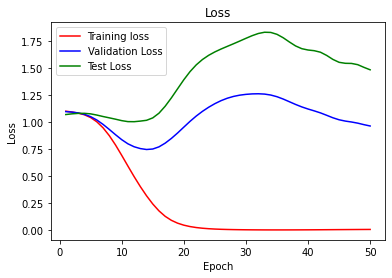

In [13]:
x = np.linspace(1,epochs)
plt.plot(x,trainloss,'r-',label="Training loss")
plt.plot(x,valloss,'b-',label="Validation Loss")
plt.plot(x,testloss,'g-',label="Test Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

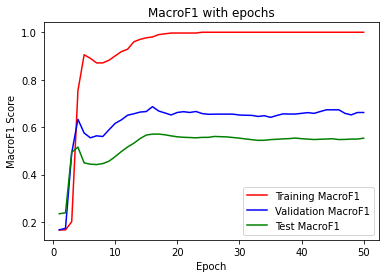

In [14]:
x = np.linspace(1,epochs)
plt.plot(x,trainf1,'r-',label="Training MacroF1")
plt.plot(x,valf1,'b-',label="Validation MacroF1")
plt.plot(x,testf1,'g-',label="Test MacroF1")
plt.title("MacroF1 with epochs")
plt.xlabel("Epoch")
plt.ylabel("MacroF1 Score")
plt.legend()
plt.show()